In [198]:
# check available gpus
# !nvidia-smi

In [199]:
import torch
import matplotlib.pyplot as plt

# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


In [200]:
# learn texture from image
from modules.Renderer import Renderer
from modules.utils import remove_background ,squared_image

verts_T_paths = ['data/verts_T/0002_c1s2_064446_01.pkl']
# verts_T_paths = ['data/verts_T/0002_c2s1_123141_01.pkl']
euler_list = [[0,0,0]]#,[0,0,180]]

tm_paths = ['data/meta/default_texture.jpg']
# tm_paths = ['changed_texture_fpp_1.jpg']

image_path = 'data/images/0002_c1s2_064446_01.jpg'
seg_mask_path = "data/seg/0002_c1s2_064446_01.png" 

In [201]:
image_resolution = 256#128#256 # 512

In [202]:
renderer = Renderer(image_resolution=image_resolution,device=device,blur_radius=0.0)
print("1")
renderer.load_inputs(verts_T_paths,tm_paths = tm_paths,
                     euler_list = euler_list)
print("2")
images = renderer.render()

1
2


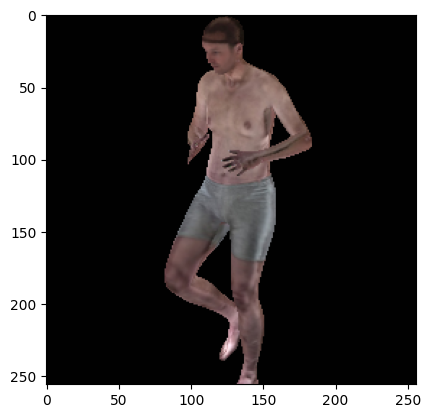

In [203]:
renderer.show()

In [204]:

tgt = remove_background(image_path,seg_mask_path)
tgt = squared_image(tgt)
# plt.imshow(tgt)
# tgt.shape
# resize the image to 512,512
from skimage.transform import resize
tgt = resize(tgt,(image_resolution,image_resolution))


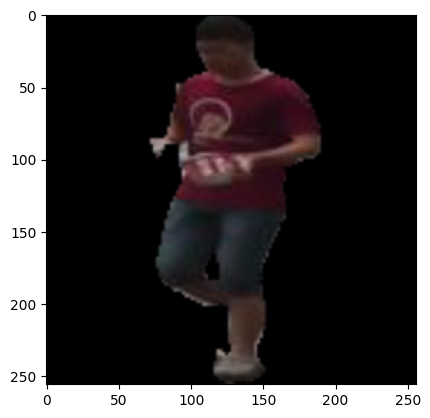

In [205]:
plt.imshow(tgt)

In [206]:
from loss_utils import PerceptualTextureLoss, tv_loss


In [207]:
texture_loss = PerceptualTextureLoss()
tgt = torch.from_numpy(tgt).permute(2,0,1).float().unsqueeze(0).to(device)


Setting up Perceptual loss..


/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cds/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [216]:
# training loop to learn texture and T from image
params = [ renderer.texture_map] #renderer.verts,renderer.T
optim = torch.optim.Adam(params,lr=0.1)


for i in range(1000):
    optim.zero_grad()
    images = renderer.render()

    images = images.permute(0,3,1,2)[:,:3,:,:].float().to(device)

    # resize both to 256,256
    
    
    perceptual_loss = texture_loss(images,tgt)
    loss = perceptual_loss # + 0.5 * tv_loss(renderer.texture_map)
    print('i :' , i,'loss:',loss.item())
    



    # diff = images[0,...,:3] - torch.from_numpy(tgt).to(device)
    # loss = torch.sum(diff**2) + 0.5 * tv_loss(renderer.texture_map)
    loss.backward()
    optim.step()
    # print(loss.item())
    if i%300 == 0:
        plt.figure(figsize=(3,3))
        plt.imshow(images[0,...,:3].cpu().detach().numpy().clip(0,1))
        plt.axis('off')
        plt.show()
        
        # print(renderer.T)
        # print(renderer.texture_map)
        # print(renderer.verts)
        print('loss:',loss.item())
 


i : 0 loss: 0.7045932412147522


loss: 0.7045932412147522
i : 1 loss: 0.7048414945602417
i : 2 loss: 0.7045004963874817
i : 3 loss: 0.7042204141616821
i : 4 loss: 0.7039474248886108
i : 5 loss: 0.7036881446838379
i : 6 loss: 0.7034420371055603
i : 7 loss: 0.7031859755516052
i : 8 loss: 0.7029280662536621
i : 9 loss: 0.7026712894439697
i : 10 loss: 0.7024239897727966
i : 11 loss: 0.7021751403808594
i : 12 loss: 0.7019280195236206
i : 13 loss: 0.7016748189926147
i : 14 loss: 0.7014296650886536
i : 15 loss: 0.7011925578117371
i : 16 loss: 0.7009517550468445
i : 17 loss: 0.7007048726081848
i : 18 loss: 0.7004560828208923
i : 19 loss: 0.7002133727073669
i : 20 loss: 0.699970006942749
i : 21 loss: 0.6997262239456177
i : 22 loss: 0.699479341506958
i : 23 loss: 0.6992272734642029
i : 24 loss: 0.698984682559967
i : 25 loss: 0.6987420320510864
i : 26 loss: 0.6984933614730835
i : 27 loss: 0.6982447504997253
i : 28 loss: 0.6979962587356567
i : 29 loss: 0.6977513432502747
i : 30 loss: 0.6975057125091553
i : 31 loss: 0.697261035442

loss: 0.6451159715652466
i : 301 loss: 0.6449548006057739
i : 302 loss: 0.6447926163673401
i : 303 loss: 0.644627571105957
i : 304 loss: 0.6444715857505798
i : 305 loss: 0.6443138718605042
i : 306 loss: 0.6441544890403748
i : 307 loss: 0.6440011858940125
i : 308 loss: 0.6438432931900024
i : 309 loss: 0.6436883211135864
i : 310 loss: 0.6435273289680481
i : 311 loss: 0.6433729529380798
i : 312 loss: 0.6432145237922668
i : 313 loss: 0.6430573463439941
i : 314 loss: 0.6429053544998169
i : 315 loss: 0.6427538394927979
i : 316 loss: 0.6425970792770386
i : 317 loss: 0.6424398422241211
i : 318 loss: 0.6422867178916931
i : 319 loss: 0.642126202583313
i : 320 loss: 0.6419774889945984
i : 321 loss: 0.6418243646621704
i : 322 loss: 0.6416678428649902
i : 323 loss: 0.6415109038352966
i : 324 loss: 0.641361653804779
i : 325 loss: 0.6412023901939392
i : 326 loss: 0.641049861907959
i : 327 loss: 0.6409000754356384
i : 328 loss: 0.6407440304756165
i : 329 loss: 0.6405929923057556
i : 330 loss: 0.640443

loss: 0.6062234044075012
i : 601 loss: 0.606112539768219
i : 602 loss: 0.6060043573379517
i : 603 loss: 0.6058976650238037
i : 604 loss: 0.605789840221405
i : 605 loss: 0.6056759357452393
i : 606 loss: 0.6055678725242615
i : 607 loss: 0.6054638624191284
i : 608 loss: 0.6053568124771118
i : 609 loss: 0.605251669883728
i : 610 loss: 0.605147123336792
i : 611 loss: 0.6050426959991455
i : 612 loss: 0.6049386262893677
i : 613 loss: 0.6048345565795898
i : 614 loss: 0.6047357320785522
i : 615 loss: 0.6046346426010132
i : 616 loss: 0.6045314073562622
i : 617 loss: 0.6044299602508545
i : 618 loss: 0.604331374168396
i : 619 loss: 0.6042308211326599
i : 620 loss: 0.6041295528411865
i : 621 loss: 0.6040322780609131
i : 622 loss: 0.6039375066757202
i : 623 loss: 0.6038376092910767
i : 624 loss: 0.6037399172782898
i : 625 loss: 0.6036428213119507
i : 626 loss: 0.6035463809967041
i : 627 loss: 0.6034473180770874
i : 628 loss: 0.6033527851104736
i : 629 loss: 0.6032523512840271
i : 630 loss: 0.6031586

loss: 0.5784254670143127
i : 901 loss: 0.578338623046875
i : 902 loss: 0.5782517194747925
i : 903 loss: 0.5781683325767517
i : 904 loss: 0.5780863165855408
i : 905 loss: 0.5779999494552612
i : 906 loss: 0.5779182314872742
i : 907 loss: 0.5778314471244812
i : 908 loss: 0.57774817943573
i : 909 loss: 0.5776649713516235
i : 910 loss: 0.5775793194770813
i : 911 loss: 0.5774962902069092
i : 912 loss: 0.5774103999137878
i : 913 loss: 0.5773260593414307
i : 914 loss: 0.5772445201873779
i : 915 loss: 0.577161967754364
i : 916 loss: 0.5770725607872009
i : 917 loss: 0.5769824981689453
i : 918 loss: 0.5768939852714539
i : 919 loss: 0.5768043398857117
i : 920 loss: 0.576716423034668
i : 921 loss: 0.576628565788269
i : 922 loss: 0.5765357613563538
i : 923 loss: 0.5764505863189697
i : 924 loss: 0.5763614773750305
i : 925 loss: 0.5762686133384705
i : 926 loss: 0.5761788487434387
i : 927 loss: 0.5760902166366577
i : 928 loss: 0.5760015249252319
i : 929 loss: 0.5759130716323853
i : 930 loss: 0.57582300

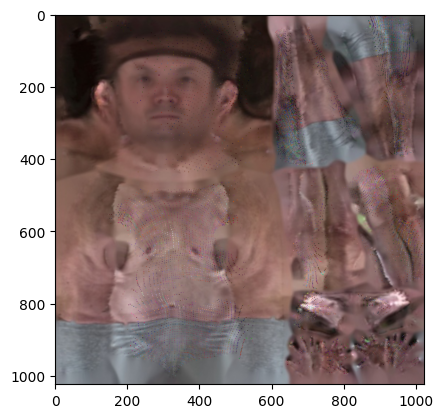

In [217]:
import numpy as np
texture = renderer.texture_map.cpu().detach().numpy()[0]
texture = texture/255
# texture = np.transpose(texture,(1,2,0))
plt.imshow(texture.clip(0,1))


In [219]:
# save texture
plt.imsave("data/exp/changed_texture_perceptual.jpg",texture.clip(0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


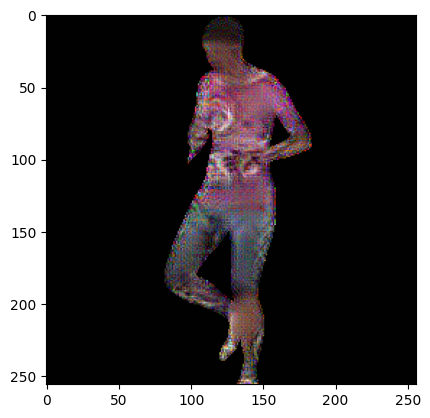

In [218]:
renderer.show()